In [51]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

La Value at Risk (VaR) représente la perte maximale potentielle d'un portefeuille sur un horizon temporel donné, avec un niveau de confiance spécifique (ex: 95%). Une VaR de -5% à 95% signifie qu'il y a 5% de chances de perdre plus de 5%.

Les tests de Kupiec/binomial vérifient si le nombre de violations (jours où la perte dépasse la VaR) correspond au niveau de confiance choisi. Par exemple, pour une VaR 95% sur 1000 jours, on devrait observer environ 50 violations. Si le nombre réel s'écarte significativement, le modèle de VaR est considéré comme mal calibré.

Le ratio put-call reflète le sentiment du marché (haussier/baissier). Intégrer ce ratio dans le calcul de la VaR permet d'anticiper les changements de volatilité : quand le marché est baissier (ratio élevé), la VaR augmente pour refléter un risque accru. Inversement, en période haussière, la VaR diminue. Cela rend la mesure de risque plus dynamique et réactive aux conditions de marché.

Ainsi on pourra comparer les résulats de la VaR classique et celle ajustée aux sentiments.
J'ai choisi de calculé la VaR historique avec bootstrap si la prof aime bien l'idée je peux le faire avec d'autres méthodes
(Simulation de Monte Carlo, GARCH, IGARCH)

In [63]:
# Fonction pour calculer la VaR historique avec bootstrap
def hist_VaR(serie, window, tail=0.05):
    n = len(serie)
    VaR = np.zeros(n)
    
    for i in range(window, n):
        z = serie[i-window:i]  # Sélectionner la fenêtre
        sample_quant = np.random.uniform(0, 1, 100000)  # Générer un échantillon uniforme
        
        sample = np.zeros(100000)
        for j in range(100000):
            rang_sample = int(np.ceil(len(z) * sample_quant[j])) - 1
            sample[j] = z[rang_sample]
        
        sample.sort()
        rang = int(np.ceil(len(sample) * tail)) - 1
        VaR[i] = sample[rang]
    
    return VaR

# Fonction pour ajuster la VaR selon le sentiment basé sur le ratio Put-Call
def adjust_var_with_sentiment(VaR_hist, put_call_ratio):
    VaR_adjusted = VaR_hist.copy()
    for i, pcr in enumerate(put_call_ratio):
        if pcr < 0.7:  # Bullish
            VaR_adjusted[i] *= 0.9  # Réduction de 10 % (on peut jouer sur ça)
        elif pcr > 1.2:  # Bearish
            VaR_adjusted[i] *= 1.1  # Augmentation de 10 %
    return VaR_adjusted

# Charger les fichiers CSV des 5 actifs
data_folder = '/Users/maro/projet_finance/finance/new_data/financial_data_putcall'
files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]

# Appliquer le calcul de la VaR et l'ajustement pour chaque actif
results = []

for file in files:
    df = pd.read_csv(os.path.join(data_folder, file))
    
    # Extraire les colonnes nécessaires
    serie = df['Daily Return'].values
    put_call_ratio = df['Put-Call Ratio'].values
    
    # Paramètres
    window = 252  # Fenêtre de 1 an
    tail = 0.05  # 5% quantile pour la VaR
    
    # Calcul de la VaR historique
    VaR_hist = hist_VaR(serie, window, tail)
    
    # Ajuster la VaR avec le sentiment
    VaR_adjusted = adjust_var_with_sentiment(VaR_hist, put_call_ratio)
    
    df['VaR_Hist'] = VaR_hist
    df['VaR_Adjusted'] = VaR_adjusted
    

    asset_name = file.split('_')[0]  # Prendre la première partie avant "_updated_financial_data"
    df['Asset'] = asset_name
    
    results.append(df)

# Fusionner les résultats et les sauvegarder dans un nouveau fichier CSV
final_df = pd.concat(results, ignore_index=True)
final_df.to_csv('/Users/maro/projet_finance/finance/new_data/financial_data_with_var_historique_boostrap.csv', index=False)

print("Les résultats ont été enregistrés dans financial_data_with_var_historique_boostrap.csv.")


Les résultats ont été enregistrés dans financial_data_with_var_historique_boostrap.csv.


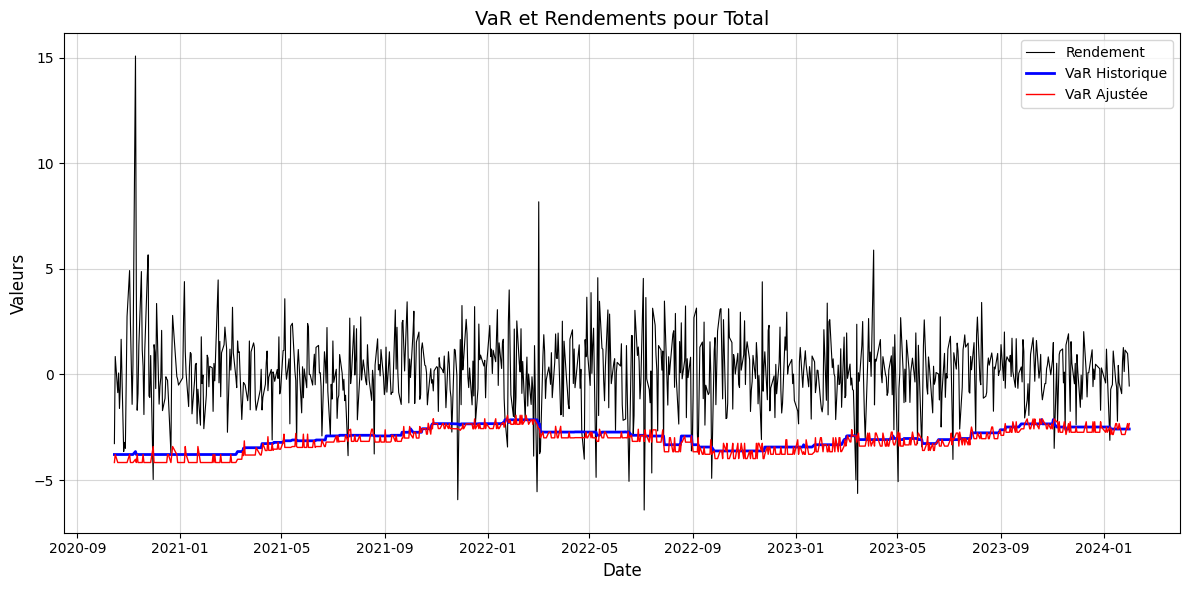

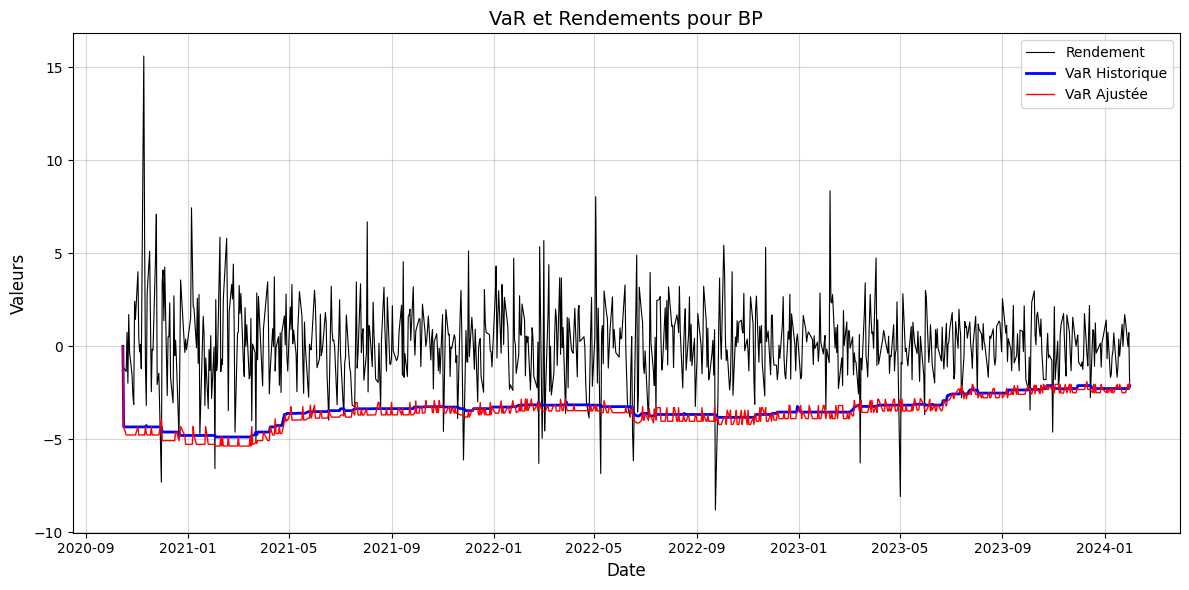

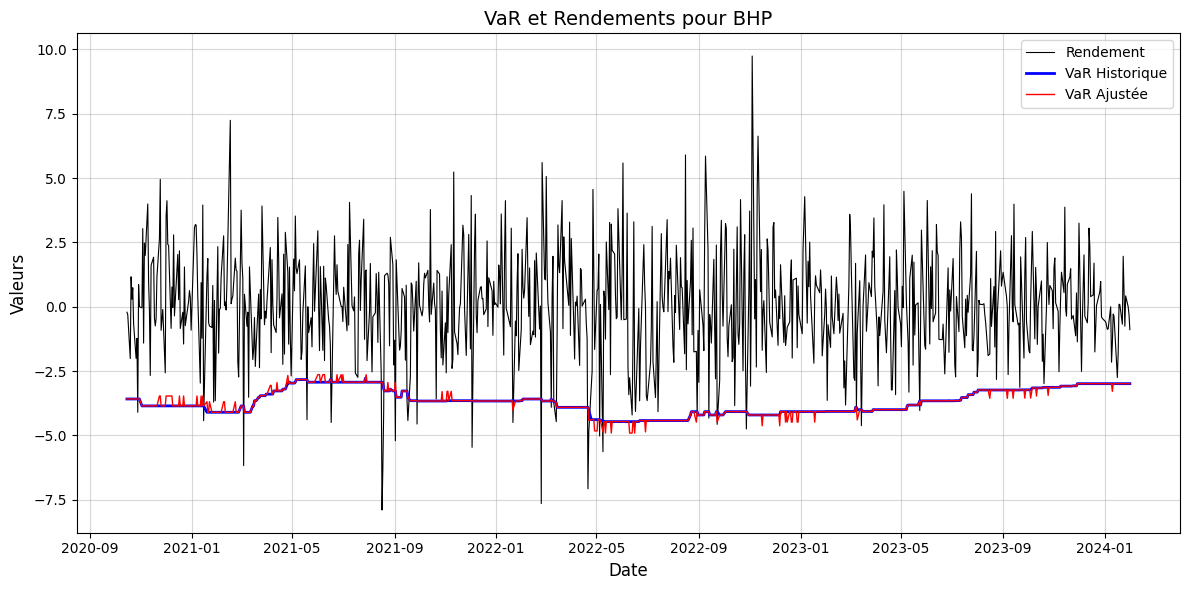

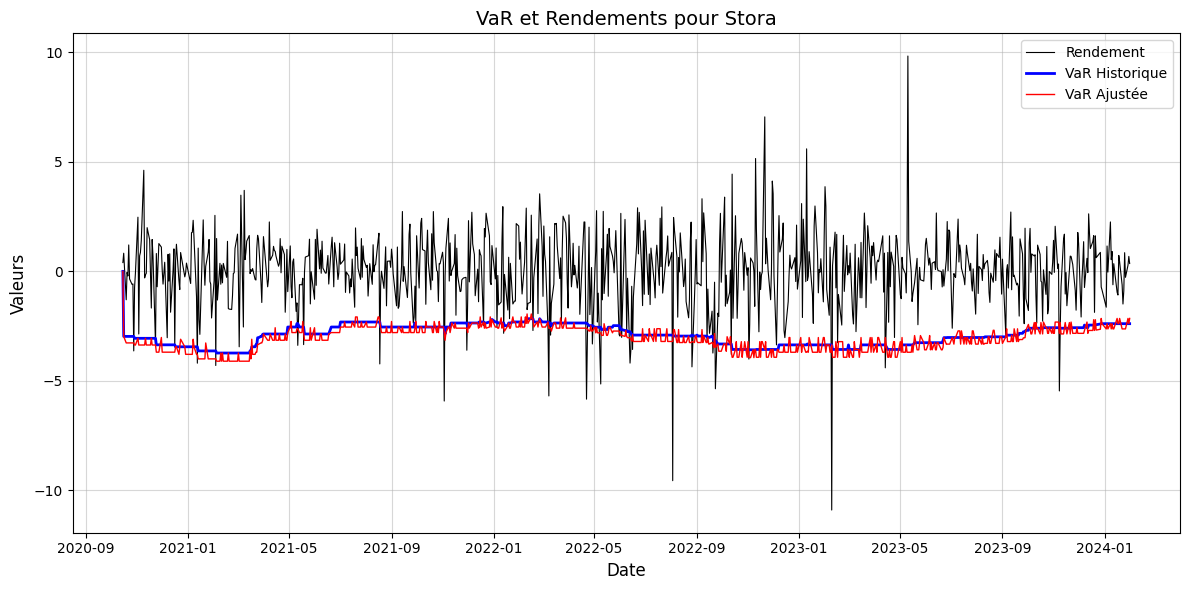

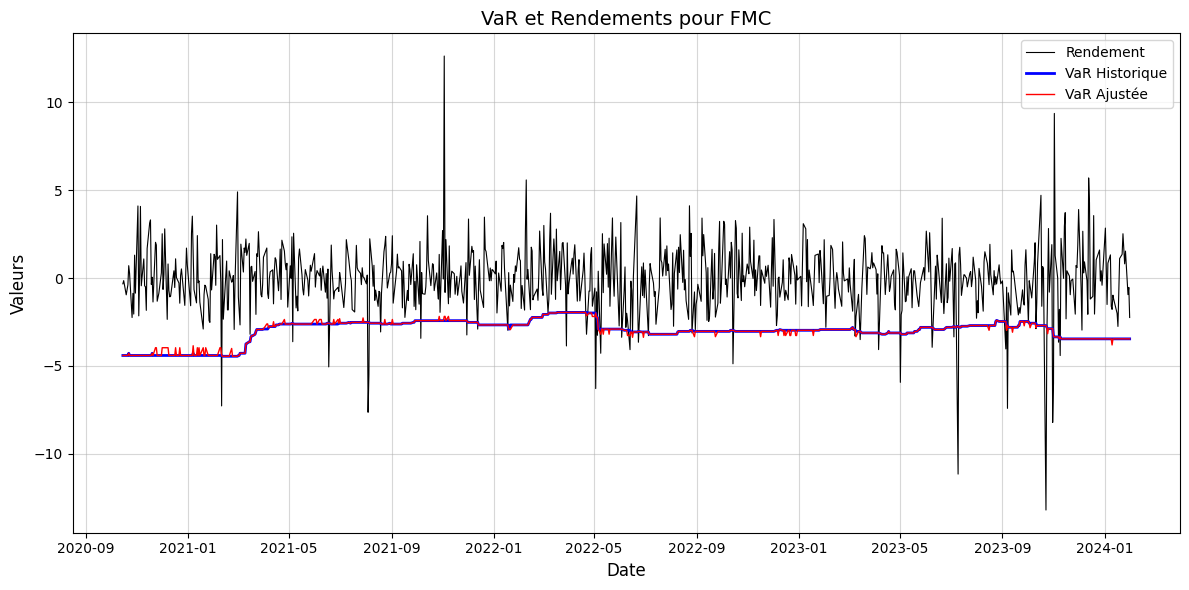

In [64]:
file_path = '/Users/maro/projet_finance/finance/new_data/financial_data_with_var_historique_boostrap.csv'
data = pd.read_csv(file_path)

data['Date'] = pd.to_datetime(data['Date'])
# Filtrer les données à partir de 2020-10-15
data = data[data['Date'] >= '2020-10-15']
assets = data['Asset'].unique()

# Créer un graphique pour chaque actif
for asset in assets:
    # Filtrer les données pour l'actif en cours
    asset_data = data[data['Asset'] == asset]
    
    plt.figure(figsize=(12, 6))
    plt.plot(asset_data['Date'], asset_data['Daily Return'], label='Rendement', color='black', linewidth=0.8)
    plt.plot(asset_data['Date'], asset_data['VaR_Hist'], label='VaR Historique', color='blue', linewidth=2)
    plt.plot(asset_data['Date'], asset_data['VaR_Adjusted'], label='VaR Ajustée', color='red', linewidth=1)
    plt.title(f"VaR et Rendements pour {asset}", fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Valeurs', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()


In [65]:
import numpy as np
import pandas as pd
from scipy.stats import chi2, norm

def kupiec_test(returns, var, alpha=0.05):
    """
    Test de Kupiec pour valider la VaR.
    """
    violations = returns < var
    T = len(returns)  # Nombre total d'observations
    N = violations.sum()  # Nombre de violations de la VaR
    m = T - N
    tho = N / T if T > 0 else 0  # Taux de violation observé

    if N == 0 or T == 0 or tho == 0:
        return {
            "Total Observations": T,
            "Violations": N,
            "Observed Violation Rate": round(tho, 4),
            "Kupiec Statistic": np.nan,
            "P-Value": np.nan
        }

    # Statistique du test
    kupiec_stat = -2 * np.log(((1 - alpha)**m * alpha**N) / ((1 - tho)**m * tho**N))
    p_value = 1 - chi2.cdf(kupiec_stat, df=1)

    return {
        "Total Observations": T,
        "Violations": N,
        "Observed Violation Rate": round(tho, 4),
        "Kupiec Statistic": round(kupiec_stat, 4),
        "P-Value": round(p_value, 4)
    }

def binomial_test(returns, var, alpha=0.01):
    """
    Test binomial pour valider la VaR.
    """
    violations = returns < var
    T = len(returns)  # Nombre total d'observations
    N = violations.sum()  # Nombre de violations

    if T == 0 or T * alpha * (1 - alpha) == 0:
        return {
            "Total Observations": T,
            "Violations": N,
            "Binomial Statistic": np.nan,
            "P-Value": np.nan
        }

    # Statistique du test binomial
    binomial_stat = (N - (T * alpha)) / np.sqrt(T * alpha * (1 - alpha))
    p_value = 2 * (1 - norm.cdf(abs(binomial_stat)))

    return {
        "Total Observations": T,
        "Violations": N,
        "Binomial Statistic": round(binomial_stat, 4),
        "P-Value": round(p_value, 4)
    }

# Charger les données
file_path = '/Users/maro/projet_finance/finance/new_data/financial_data_with_var_historique_boostrap.csv'
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'])

# Filtrer les données à partir de la date souhaitée
data = data[data['Date'] >= '2020-10-15']

# Liste des actifs uniques
assets = data['Asset'].unique()

# Initialiser les listes pour les résultats
kupiec_results = []
binomial_results = []

# Appliquer les tests pour chaque actif
for asset in assets:
    asset_data = data[data['Asset'] == asset]  # Filtrer les données par actif
    returns = asset_data['Daily Return']
    var_hist = asset_data['VaR_Hist']
    var_adjusted = asset_data['VaR_Adjusted']

    # Test de Kupiec pour VaR_Hist
    kupiec_hist = kupiec_test(returns, var_hist, alpha=0.05)
    kupiec_hist['Asset'] = asset  # Ajouter le nom de l'actif
    kupiec_hist['VaR Type'] = 'VaR_Hist'  # Ajouter le type de VaR
    kupiec_results.append(kupiec_hist)

    # Test binomial pour VaR_Hist
    binomial_hist = binomial_test(returns, var_hist, alpha=0.05)
    binomial_hist['Asset'] = asset  # Ajouter le nom de l'actif
    binomial_hist['VaR Type'] = 'VaR_Hist'  # Ajouter le type de VaR
    binomial_results.append(binomial_hist)

    # Test de Kupiec pour VaR_Adjusted
    kupiec_adjusted = kupiec_test(returns, var_adjusted, alpha=0.05)
    kupiec_adjusted['Asset'] = asset  # Ajouter le nom de l'actif
    kupiec_adjusted['VaR Type'] = 'VaR_Adjusted'  # Ajouter le type de VaR
    kupiec_results.append(kupiec_adjusted)

    # Test binomial pour VaR_Adjusted
    binomial_adjusted = binomial_test(returns, var_adjusted, alpha=0.05)
    binomial_adjusted['Asset'] = asset  # Ajouter le nom de l'actif
    binomial_adjusted['VaR Type'] = 'VaR_Adjusted'  # Ajouter le type de VaR
    binomial_results.append(binomial_adjusted)

# Convertir les résultats en DataFrame pour les exporter
kupiec_df = pd.DataFrame(kupiec_results)
binomial_df = pd.DataFrame(binomial_results)

# Sauvegarder les résultats dans des fichiers CSV
kupiec_df.to_csv('/Users/maro/projet_finance/finance/new_data/boostrap_kupiec_test_results_by_asset.csv', index=False)
binomial_df.to_csv('/Users/maro/projet_finance/finance/new_data/boostrap_binomial_test_results_by_asset.csv', index=False)

print("Résultats des tests de Kupiec et binomial sauvegardés avec succès pour chaque actif et chaque type de VaR.")


Résultats des tests de Kupiec et binomial sauvegardés avec succès pour chaque actif et chaque type de VaR.


In [66]:
kupiec_df

,Total Observations,Violations,Observed Violation Rate,Kupiec Statistic,P-Value,Asset,VaR Type
0,833,32,0.0384,2.5490,0.1104,Total,VaR_Hist
1,833,32,0.0384,2.5490,0.1104,Total,VaR_Adjusted
2,812,32,0.0394,2.0615,0.1511,BP,VaR_Hist
3,812,30,0.0369,3.1908,0.0741,BP,VaR_Adjusted
4,804,29,0.0361,3.6223,0.0570,BHP,VaR_Hist
5,804,29,0.0361,3.6223,0.0570,BHP,VaR_Adjusted
6,812,38,0.0468,0.1789,0.6723,Stora,VaR_Hist
7,812,35,0.0431,0.8512,0.3562,Stora,VaR_Adjusted
8,804,38,0.0473,0.1290,0.7195,FMC,VaR_Hist
9,804,38,0.0473,0.1290,0.7195,FMC,VaR_Adjusted


Une mauvaise calibration de la VaR signifie que le nombre réel de violations diffère significativement du niveau attendu de 5% (alpha). Dans ces résultats :

- VaR bien calibrée : Total, BP, BH (p-values > 0.05)
- Les taux de violation observés (3.61% - 4.73%) sont proches des 5% attendus
- FMC et Stora montrent les meilleures calibrations (p-values > 0.6)

Une mauvaise calibration implique que le modèle sous-estime ou surestime systématiquement le risque réel, rendant la gestion des risques moins fiable.

Selon ces résultats, la VaR ajustée montre des améliorations légères :

Pour Stora : Taux de violation plus proche de 5% (4.31% vs 4.68%)
Pour BP : P-value légèrement meilleure (0.0741 vs 0.1511)
Pour Total : Performance identique

Globalement, la différence entre VaR historique et ajustée n'est pas significative, suggérant que l'ajustement par le ratio put-call n'apporte qu'une amélioration marginale.

Voir les différences entre les fichiers

In [50]:
import os
import pandas as pd

# Chemin du dossier contenant les fichiers
folder_path = "/Users/maro/projet_finance/finance/new_data/financial_data_putcall"

# Récupérer la liste des fichiers
file_list = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Charger les fichiers dans des DataFrames
data_frames = {}
for file in file_list:
    file_path = os.path.join(folder_path, file)
    data_frames[file] = pd.read_csv(file_path)

# Comparer les plages de dates et les nombres d'observations
date_ranges = {}
for file, df in data_frames.items():
    df['Date'] = pd.to_datetime(df['Date'])  # Assurer que la colonne Date est en datetime
    date_ranges[file] = (df['Date'].min(), df['Date'].max(), len(df))

# Identifier les différences
report = pd.DataFrame.from_dict(date_ranges, orient='index', columns=['Start Date', 'End Date', 'Number of Observations'])
print("Comparaison des plages de dates et du nombre d'observations :")
print(report)

# Identifier les dates manquantes dans chaque fichier
all_dates = pd.concat([df['Date'] for df in data_frames.values()]).drop_duplicates().sort_values()

missing_dates = {}
for file, df in data_frames.items():
    missing_dates[file] = all_dates[~all_dates.isin(df['Date'])]

# Afficher les dates manquantes pour chaque fichier
for file, dates in missing_dates.items():
    print(f"\nDates manquantes dans le fichier {file} :")
    print(dates.tolist())

# Vérifier les doublons
for file, df in data_frames.items():
    duplicates = df[df.duplicated(subset=['Date'], keep=False)]
    if not duplicates.empty:
        print(f"\nDoublons trouvés dans le fichier {file} :")
        print(duplicates)


Comparaison des plages de dates et du nombre d'observations :
                                          Start Date   End Date  \
Total_Energies_updated_financial_data.csv 2019-10-07 2024-01-31   
BP_PLC_updated_financial_data.csv         2019-10-07 2024-01-31   
BHP_Group_updated_financial_data.csv      2019-10-07 2024-01-31   
Stora_Enso_updated_financial_data.csv     2019-10-07 2024-01-31   
FMC_Corp_updated_financial_data.csv       2019-10-07 2024-01-31   

                                           Number of Observations  
Total_Energies_updated_financial_data.csv                    1090  
BP_PLC_updated_financial_data.csv                            1063  
BHP_Group_updated_financial_data.csv                         1061  
Stora_Enso_updated_financial_data.csv                        1063  
FMC_Corp_updated_financial_data.csv                          1061  

Dates manquantes dans le fichier Total_Energies_updated_financial_data.csv :
[Timestamp('2019-12-24 00:00:00'), Timestamp('201

# Amélioration suggérer par ChatGPT :
On evite de choisir un seui (10%) et on fait un ajustement proportionel à l'ecart
Peut-être à réfinir nous même

Ajustements proportionnels :
Exemples pour un ratio Put-Call :

- Ratio = 0.5 (très bullish) :
-Distance à la valeur neutre (1.0) : |0.5 - 1.0| = 0.5
Ajustement : réduction de 0.1 * 0.5 = 0.05 → La VaR est réduite de 5 %.
- Ratio = 1.5 (très bearish) :
-Distance à la valeur neutre (1.0) : |1.5 - 1.0| = 0.5
-Ajustement : augmentation de 0.1 * 0.5 = 0.05 → La VaR est augmentée de 5 %.
- Ratio = 1.1 (léger bearish) :
-Distance à la valeur neutre (1.0) : |1.1 - 1.0| = 0.1
-Ajustement : augmentation de 0.1 * 0.1 = 0.01 → La VaR est augmentée de 1 %.
- Ratio = 0.9 (neutre) :
-Pas d’ajustement, car le ratio est compris entre 0.7 et 1.2.

In [67]:
# Fonction pour calculer la VaR historique avec bootstrap
def hist_VaR(serie, window, tail=0.05):
    n = len(serie)
    VaR = np.zeros(n)
    
    for i in range(window, n):
        z = serie[i-window:i]  # Sélectionner la fenêtre
        sample_quant = np.random.uniform(0, 1, 100000)  # Générer un échantillon uniforme
        
        sample = np.zeros(100000)
        for j in range(100000):
            rang_sample = int(np.ceil(len(z) * sample_quant[j])) - 1
            sample[j] = z[rang_sample]
        
        sample.sort()
        rang = int(np.ceil(len(sample) * tail)) - 1
        VaR[i] = sample[rang]
    
    return VaR

# Fonction pour ajuster la VaR selon le sentiment basé sur le ratio Put-Call
def adjust_var_with_fixed_thresholds(VaR_hist, put_call_ratio, neutral_value=1.0, bearish_threshold=1.2, bullish_threshold=0.7):
    VaR_adjusted = VaR_hist.copy()
    
    for i, pcr in enumerate(put_call_ratio):
        if pcr < bullish_threshold:  # Bullish sentiment
            adjustment = 1 - 0.1 * abs(pcr - neutral_value)  # Réduction proportionnelle
            VaR_adjusted[i] *= max(0.8, adjustment)  # Limite à une réduction maximale de 20%
        elif pcr > bearish_threshold:  # Bearish sentiment
            adjustment = 1 + 0.1 * abs(pcr - neutral_value)  # Augmentation proportionnelle
            VaR_adjusted[i] *= min(1.3, adjustment)  # Limite à une augmentation maximale de 30%
        # Si pcr est entre 0.7 et 1.2, pas d'ajustement
    return VaR_adjusted

# Charger les fichiers CSV des 5 actifs
data_folder = '/Users/maro/projet_finance/finance/new_data/financial_data_putcall'
files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]

# Appliquer le calcul de la VaR et l'ajustement pour chaque actif
results = []

for file in files:
    df = pd.read_csv(os.path.join(data_folder, file))
    
    # Extraire les colonnes nécessaires
    serie = df['Daily Return'].values
    put_call_ratio = df['Put-Call Ratio'].values
    
    # Paramètres
    window = 252  # Fenêtre de 1 an
    tail = 0.05  # 5% quantile pour la VaR
    
    # Calcul de la VaR historique
    VaR_hist = hist_VaR(serie, window, tail)
    
    # Ajuster la VaR avec le sentiment
    VaR_adjusted = adjust_var_with_sentiment(VaR_hist, put_call_ratio)
    
    df['VaR_Hist'] = VaR_hist
    df['VaR_Adjusted'] = VaR_adjusted
    

    asset_name = file.split('_')[0]  # Prendre la première partie avant "_updated_financial_data"
    df['Asset'] = asset_name
    
    results.append(df)

# Fusionner les résultats et les sauvegarder dans un nouveau fichier CSV
final_df = pd.concat(results, ignore_index=True)
final_df.to_csv('/Users/maro/projet_finance/finance/new_data/financial_data_with_var_historique_boostrap_ajustement.csv', index=False)

print("Les résultats ont été enregistrés dans financial_data_with_var_historique_boostrap_ajustement.csv.")

Les résultats ont été enregistrés dans financial_data_with_var_historique_boostrap_ajustement.csv.


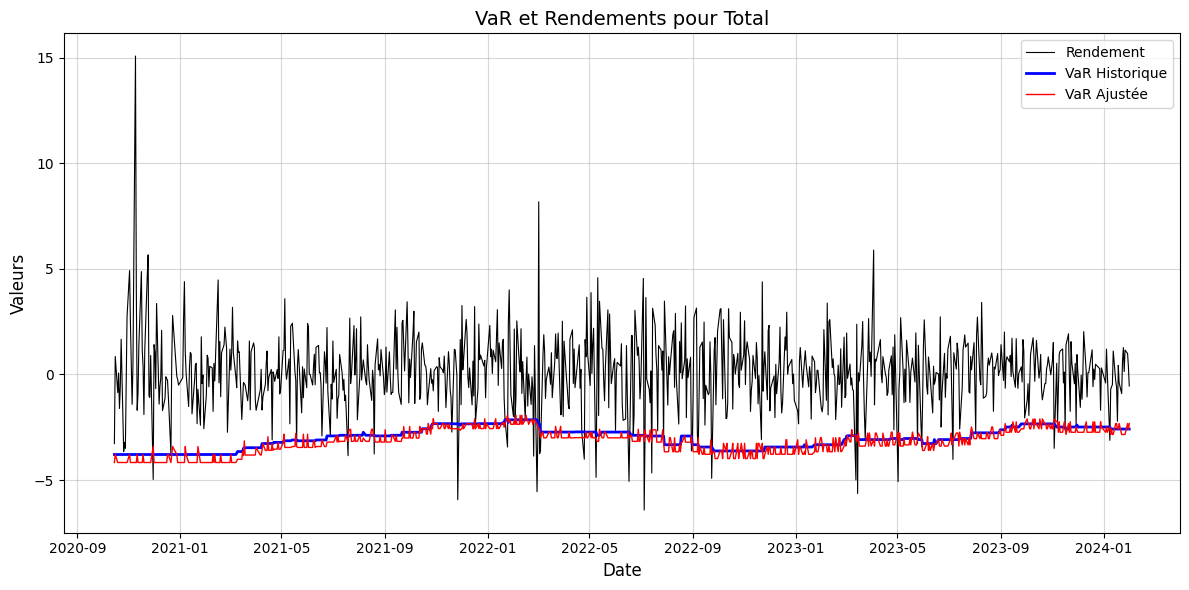

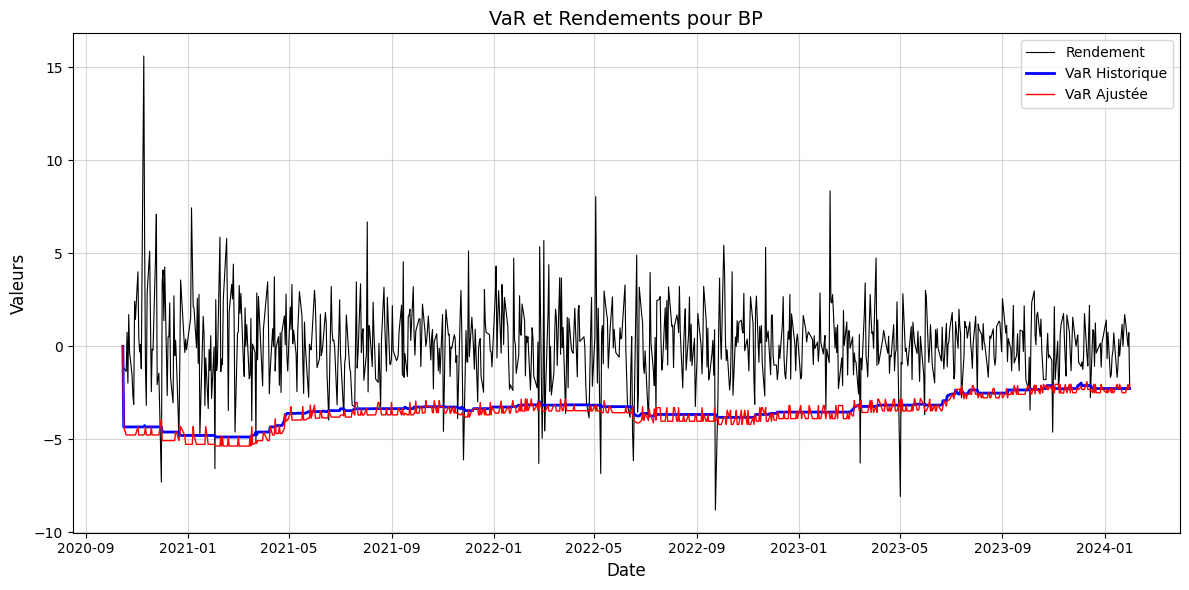

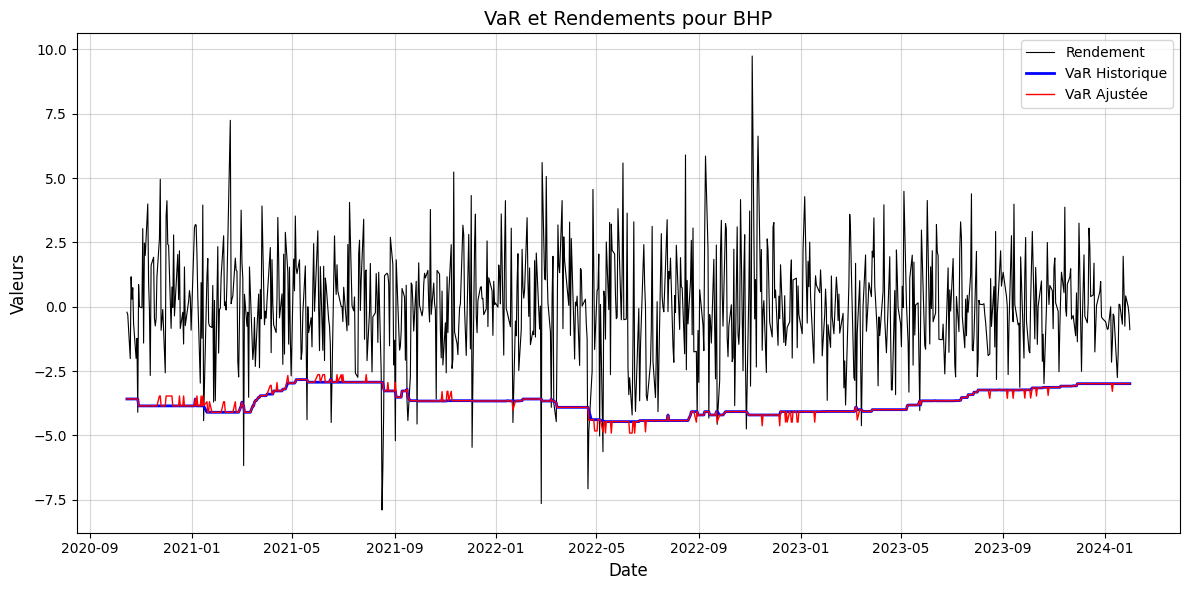

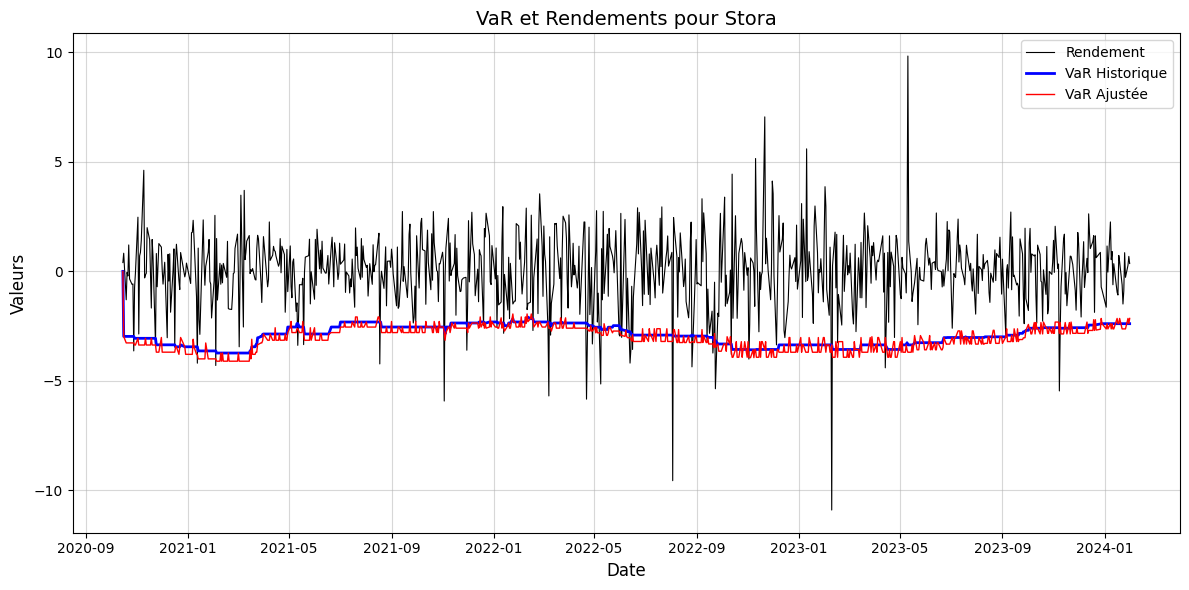

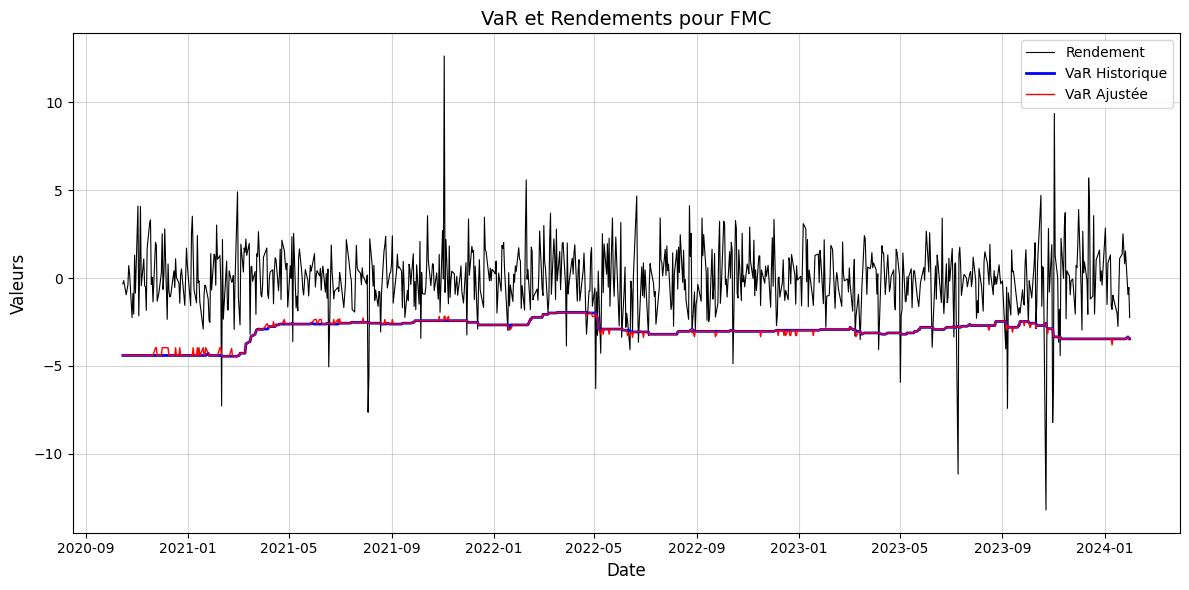

In [68]:
file_path = '/Users/maro/projet_finance/finance/new_data/financial_data_with_var_historique_boostrap_ajustement.csv'
data = pd.read_csv(file_path)

data['Date'] = pd.to_datetime(data['Date'])
# Filtrer les données à partir de 2020-10-15
data = data[data['Date'] >= '2020-10-15']
assets = data['Asset'].unique()

# Créer un graphique pour chaque actif
for asset in assets:
    # Filtrer les données pour l'actif en cours
    asset_data = data[data['Asset'] == asset]
    
    plt.figure(figsize=(12, 6))
    plt.plot(asset_data['Date'], asset_data['Daily Return'], label='Rendement', color='black', linewidth=0.8)
    plt.plot(asset_data['Date'], asset_data['VaR_Hist'], label='VaR Historique', color='blue', linewidth=2)
    plt.plot(asset_data['Date'], asset_data['VaR_Adjusted'], label='VaR Ajustée', color='red', linewidth=1)
    plt.title(f"VaR et Rendements pour {asset}", fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Valeurs', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

In [69]:
import numpy as np
import pandas as pd
from scipy.stats import chi2, norm

def kupiec_test(returns, var, alpha=0.05):
    """
    Test de Kupiec pour valider la VaR.
    """
    violations = returns < var
    T = len(returns)  # Nombre total d'observations
    N = violations.sum()  # Nombre de violations de la VaR
    m = T - N
    tho = N / T if T > 0 else 0  # Taux de violation observé

    if N == 0 or T == 0 or tho == 0:
        return {
            "Total Observations": T,
            "Violations": N,
            "Observed Violation Rate": round(tho, 4),
            "Kupiec Statistic": np.nan,
            "P-Value": np.nan
        }

    # Statistique du test
    kupiec_stat = -2 * np.log(((1 - alpha)**m * alpha**N) / ((1 - tho)**m * tho**N))
    p_value = 1 - chi2.cdf(kupiec_stat, df=1)

    return {
        "Total Observations": T,
        "Violations": N,
        "Observed Violation Rate": round(tho, 4),
        "Kupiec Statistic": round(kupiec_stat, 4),
        "P-Value": round(p_value, 4)
    }

def binomial_test(returns, var, alpha=0.01):
    """
    Test binomial pour valider la VaR.
    """
    violations = returns < var
    T = len(returns)  # Nombre total d'observations
    N = violations.sum()  # Nombre de violations

    if T == 0 or T * alpha * (1 - alpha) == 0:
        return {
            "Total Observations": T,
            "Violations": N,
            "Binomial Statistic": np.nan,
            "P-Value": np.nan
        }

    # Statistique du test binomial
    binomial_stat = (N - (T * alpha)) / np.sqrt(T * alpha * (1 - alpha))
    p_value = 2 * (1 - norm.cdf(abs(binomial_stat)))

    return {
        "Total Observations": T,
        "Violations": N,
        "Binomial Statistic": round(binomial_stat, 4),
        "P-Value": round(p_value, 4)
    }

# Charger les données
file_path = '/Users/maro/projet_finance/finance/new_data/financial_data_with_var_historique_boostrap_ajustement.csv'
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'])

# Filtrer les données à partir de la date souhaitée
data = data[data['Date'] >= '2020-10-15']

# Liste des actifs uniques
assets = data['Asset'].unique()

# Initialiser les listes pour les résultats
kupiec_results = []
binomial_results = []

# Appliquer les tests pour chaque actif
for asset in assets:
    asset_data = data[data['Asset'] == asset]  # Filtrer les données par actif
    returns = asset_data['Daily Return']
    var_hist = asset_data['VaR_Hist']
    var_adjusted = asset_data['VaR_Adjusted']

    # Test de Kupiec pour VaR_Hist
    kupiec_hist = kupiec_test(returns, var_hist, alpha=0.05)
    kupiec_hist['Asset'] = asset  # Ajouter le nom de l'actif
    kupiec_hist['VaR Type'] = 'VaR_Hist'  # Ajouter le type de VaR
    kupiec_results.append(kupiec_hist)

    # Test binomial pour VaR_Hist
    binomial_hist = binomial_test(returns, var_hist, alpha=0.05)
    binomial_hist['Asset'] = asset  # Ajouter le nom de l'actif
    binomial_hist['VaR Type'] = 'VaR_Hist'  # Ajouter le type de VaR
    binomial_results.append(binomial_hist)

    # Test de Kupiec pour VaR_Adjusted
    kupiec_adjusted = kupiec_test(returns, var_adjusted, alpha=0.05)
    kupiec_adjusted['Asset'] = asset  # Ajouter le nom de l'actif
    kupiec_adjusted['VaR Type'] = 'VaR_Adjusted'  # Ajouter le type de VaR
    kupiec_results.append(kupiec_adjusted)

    # Test binomial pour VaR_Adjusted
    binomial_adjusted = binomial_test(returns, var_adjusted, alpha=0.05)
    binomial_adjusted['Asset'] = asset  # Ajouter le nom de l'actif
    binomial_adjusted['VaR Type'] = 'VaR_Adjusted'  # Ajouter le type de VaR
    binomial_results.append(binomial_adjusted)

# Convertir les résultats en DataFrame pour les exporter
kupiec_df = pd.DataFrame(kupiec_results)
binomial_df = pd.DataFrame(binomial_results)

# Sauvegarder les résultats dans des fichiers CSV
kupiec_df.to_csv('/Users/maro/projet_finance/finance/new_data/ajustement_boostrap_kupiec_test_results_by_asset.csv', index=False)
binomial_df.to_csv('/Users/maro/projet_finance/finance/new_data/ajustement_boostrap_binomial_test_results_by_asset.csv', index=False)

print("Résultats des tests de Kupiec et binomial sauvegardés avec succès pour chaque actif et chaque type de VaR.")


Résultats des tests de Kupiec et binomial sauvegardés avec succès pour chaque actif et chaque type de VaR.


In [70]:
kupiec_df

,Total Observations,Violations,Observed Violation Rate,Kupiec Statistic,P-Value,Asset,VaR Type
0,833,32,0.0384,2.5490,0.1104,Total,VaR_Hist
1,833,32,0.0384,2.5490,0.1104,Total,VaR_Adjusted
2,812,31,0.0382,2.5926,0.1074,BP,VaR_Hist
3,812,30,0.0369,3.1908,0.0741,BP,VaR_Adjusted
4,804,29,0.0361,3.6223,0.0570,BHP,VaR_Hist
5,804,29,0.0361,3.6223,0.0570,BHP,VaR_Adjusted
6,812,38,0.0468,0.1789,0.6723,Stora,VaR_Hist
7,812,35,0.0431,0.8512,0.3562,Stora,VaR_Adjusted
8,804,38,0.0473,0.1290,0.7195,FMC,VaR_Hist
9,804,38,0.0473,0.1290,0.7195,FMC,VaR_Adjusted


Autre suggestion à essayer ==> Impact temporel du sentiment :
- Le ratio Put-Call reflète un sentiment momentané, mais les effets du sentiment sur les marchés peuvent persister. 
==> lisser le ratio Put-Call avec une moyenne mobile avant d'appliquer l'ajustement.
